# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using sklearn , though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = pd.read_csv('kc_house_data.csv')
sales

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [4]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in sklearn . (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
x = sales.drop(['id','date','price'] ,axis =1)
y = sales['price']
print(x.shape ,y.shape)


(21613, 22) (21613,)


In [13]:
from sklearn.model_selection import train_test_split 
x_train ,x_test ,y_train ,y_test = train_test_split(x , y, test_size = 0.5 ,random_state = 40)
print(x_train.shape ,y_train.shape )
print(x_test.shape ,y_test.shape )

(10806, 22) (10806,)
(10807, 22) (10807,)


In [14]:
from sklearn.linear_model import Lasso

model_all = Lasso(alpha = 0.1)
model_all.fit(x ,y)


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Find what features had non-zero weight.

In [15]:
model_all.coef_


array([-1.25254391e+04,  4.90898185e+04,  7.19334369e+02,  6.91648064e-01,
       -2.15267326e+04,  5.73929920e+05,  4.71910222e+04,  3.42111148e+04,
        1.01312124e+05, -1.09623994e+02, -1.22986506e+02, -2.41615194e+03,
        2.84596900e+01, -6.08222473e+02,  5.85114688e+05, -1.64071862e+05,
        4.23679393e+01, -1.27407005e-01, -4.54271766e+04, -5.09720008e+02,
        1.63680743e+02,  9.55826416e+03])

In [16]:
model_all.intercept_

16830195.65056218

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `LinearRegression()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `LinearRegression()` with `verbose = False`

In [22]:
import numpy as np
l1_penalty_values=np.logspace(1,7, num=13)
#l1_penalty_values = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
print(l1_penalty_values)

min_error=0
best_penalty=None
test_errors=[]
for l1_penalty in l1_penalty_values:
    model = Lasso(alpha = l1_penalty)
    model.fit(x_train ,y_train)
    predictions=model.predict(x_train)
    print('predictions', predictions)
    rss=((predictions-y_train)**2).sum()
    test_errors.append(rss)
    if min_error is 0 or rss<min_error:
        min_error=rss
        best_penalty=l1_penalty
print('min_error', min_error ,'best_penalty', best_penalty)


[1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06 3.16227766e+06
 1.00000000e+07]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [219362.60102225 334550.22355762 238386.13909558 ...  49349.93508861
 624365.70967354 227031.31836483]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [219502.68518653 334629.26888252 239330.92532446 ...  49804.79112229
 624269.50046523 227571.8057647 ]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [219945.67020596 334879.23215432 242318.60170541 ...  51243.17218096
 623965.2602434  229280.97700429]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221465.15445703 335706.43223233 251397.77659262 ...  55049.38710636
 623192.95624665 235211.65154663]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [230840.83345628 334637.85727802 275533.68232121 ...  57619.38253156
 623682.10810954 264344.35967581]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [254720.37949868 323820.3866461  336516.39157757 ...  79944.94155418
 625250.57155184 306417.01831191]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [308156.81539245 290950.24302742 411455.668628   ... 169937.40135995
 636629.81159108 319649.43289704]
predictions [286775.69059776 319575.69054909 354705.11715466 ... 207125.43379532
 691990.58423911 332956.97679978]
predictions [226364.27093595 347293.49406047 394227.79510041 ... 254312.94007418
 755360.5822794  344469.5248796 ]
predictions [237488.07241961 313589.44870142 424217.10042297 ... 247637.8204939
 705184.4006325  332570.21533558]
predictions [240130.61859708 307879.83568847 451573.89179166 ... 240021.0046809
 656819.70002684 307137.36372482]
predictions [225646.20169038 295334.52515208 485075.86189575 ... 247249.86570308
 614530.91442754 284578.39487094]
predictions [242241.98683671 313184.79154691 492368.73215463 ... 264488.79478936
 619347.74115762 298764.88034169]
min_error 412692754837330.5 best_penalty 10.0


In [23]:
print (min_error,best_penalty)
test_errors

412692754837330.5 10.0


[412692754837330.5,
 412698208711983.75,
 412752747618398.1,
 413251595488445.25,
 416387097180440.4,
 440107422681282.8,
 519288535165147.9,
 565323845085829.0,
 672246229893330.8,
 693153694786674.0,
 719403041587332.5,
 753865363284896.8,
 762209036101027.9]

 *** What was the best value for the `l1_penalty`?

In [24]:
best_penalty
#using test data best rss (with using best_penalty)
model = Lasso(alpha= best_penalty)
model.fit(x_train ,y_train)
price_predicted = model.predict(x_test)
print('price_predicted', price_predicted)
RSS = ((price_predicted-y_test)**2).sum()
print ('RSS', RSS)

price_predicted [1057109.2527447   692897.28310538  282588.24063628 ...  862125.93988311
  353162.27211694  286040.33019827]
RSS 397448272456179.6


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [25]:
model.coef_

array([ 2.01037396e+04,  5.24430540e+04,  7.23308357e+02,  5.90388750e-01,
       -4.74285891e+04,  6.50648323e+05,  4.45505689e+04,  3.36137824e+04,
        9.99760117e+04, -1.00310387e+02, -1.26723518e+02, -2.49570007e+03,
        3.83148220e+01, -6.37050021e+02,  5.96909056e+05, -1.76981714e+05,
        5.07887900e+01, -2.14756233e-01, -4.63182464e+04, -4.51869235e+02,
       -4.98438960e+03,  1.52399419e+04])

In [27]:
model.intercept_

17654814.600524537

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [28]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [29]:
l1_penalty_values = np.logspace(8, 10, num=20)
l1_penalty_values
# as value of l1_penalty(lasso )increases then its removes non _zeroes 

array([1.00000000e+08, 1.27427499e+08, 1.62377674e+08, 2.06913808e+08,
       2.63665090e+08, 3.35981829e+08, 4.28133240e+08, 5.45559478e+08,
       6.95192796e+08, 8.85866790e+08, 1.12883789e+09, 1.43844989e+09,
       1.83298071e+09, 2.33572147e+09, 2.97635144e+09, 3.79269019e+09,
       4.83293024e+09, 6.15848211e+09, 7.84759970e+09, 1.00000000e+10])

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `LinearRegression()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an Array with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [30]:
#l-l1_penalty_values=np.logspace(8, 10, num=20)
min_l_error=0
test1_error=[]
best_l_l1_penalty=None
for l1_penalty in l1_penalty_values:
    model1 = Lasso(alpha = l1_penalty)
    model1.fit(x_train ,y_train)
    predictions=model1.predict(x_train)
    print('predictions', predictions)
    rss=((predictions-y_train)**2).sum()
    test1_error.append(rss)
   
    if min_l_error is 0 or rss<min_l_error:
        min_l_error=rss
        best_l_l1_penalty=l1_penalty
        
print ('min_l_error', min_l_error ,'best_l_l1_penalty', best_l_l1_penalty)

predictions [372168.45176052 426406.15735175 514597.24156473 ... 386569.29843544
 603526.91554221 403691.39251096]
predictions [405484.78913389 448446.8587729  519283.27576858 ... 416537.57539109
 589885.40580396 430721.56872146]
predictions [447938.96446403 476532.77326124 525254.5719367  ... 454725.40108029
 572502.37117729 465165.44612565]
predictions [502441.14414523 512143.34224633 532721.72948596 ... 503445.01841746
 549644.66699466 509264.02427823]
predictions [539221.19604764 536301.62726975 537867.73436482 ... 536417.51146992
 534468.33589074 539051.39143332]
predictions [539368.7011203  536858.20704725 538223.66375022 ... 536884.74009097
 535211.20814298 539278.70649548]
predictions [539556.66608184 537567.44409357 538677.21758735 ... 537480.12034858
 536157.83309283 539568.3704016 ]
predictions [539851.59372075 538121.8003995  539092.37245282 ... 538024.3328043
 536875.24115554 539878.26906259]
predictions [540238.34770277 538758.07162434 539588.64171342 ... 538674.663423
 5

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [31]:
l1_penalty_min = 297.63
l1_penalty_max = 379.73

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [32]:
#this is reverse technique to get back that l1_penalty value we got as min above
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `LinearRegression()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [33]:
min_l_error=0
test2_error=[]
best_l_l1_penalty=None
for l1_penalty in l1_penalty_values:
    model2 = Lasso(alpha = l1_penalty)
    model2.fit(x_train ,y_train)
    predictions=model2.predict(x_train)
    print('predictions', predictions)
    rss=((predictions-y_train)**2).sum()
    test2_error.append(rss)
    if min_l_error is 0 or rss<min_l_error:
        min_l_error=rss
        best_l_l1_penalty=l1_penalty
        
print ('min_l_error', min_l_error ,'best_l_l1_penalty', best_l_l1_penalty)

C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221282.89856768 335619.31257595 250777.11867825 ...  55044.66070702
 623176.89369405 234473.02456077]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221325.24437075 335639.55417776 250921.32392857 ...  55045.75885245
 623180.62570733 234644.6390494 ]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221367.59017184 335659.7957815  251065.52917932 ...  55046.85699656
 623184.35772167 234816.25353705]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221409.93597164 335680.03738653 251209.73443037 ...  55047.9551398
 623188.08973672 234987.86802403]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221452.2817705  335700.27899248 251353.93968161 ...  55049.0532824
 623191.82175228 235159.48251054]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221494.62756867 335720.5205991  251498.144933   ...  55050.15142456
 623195.55376822 235331.09699671]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221536.97336633 335740.76220624 251642.35018454 ...  55051.24956636
 623199.28578445 235502.71148261]
predictions [221579.31916356 335761.00381377 251786.55543614 ...  55052.34770788
 623203.01780088 235674.32596829]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221621.66496047 335781.24542164 251930.76068782 ...  55053.44584918
 623206.74981752 235845.94045382]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221664.01075709 335801.48702981 252074.96593959 ...  55054.5439903
 623210.48183431 236017.5549392 ]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221706.35655348 335821.72863819 252219.17119139 ...  55055.64213125
 623214.21385123 236189.16942446]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221748.70234967 335841.97024678 252363.37644323 ...  55056.74027209
 623217.94586825 236360.78390963]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221791.0481457  335862.21185549 252507.58169512 ...  55057.8384128
 623221.67788535 236532.39839471]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221833.3939416  335882.45346436 252651.78694703 ...  55058.93655344
 623225.40990254 236704.01287973]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221875.73973739 335902.69507334 252795.99219896 ...  55060.03469398
 623229.14191979 236875.62736469]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221918.08553307 335922.93668241 252940.19745093 ...  55061.13283447
 623232.87393709 237047.2418496 ]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [221960.43132868 335943.17829159 253084.40270292 ...  55062.23097491
 623236.60595444 237218.85633447]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [222002.7771242  335963.41990082 253228.6079549  ...  55063.32911528
 623240.33797183 237390.47081929]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


predictions [222045.12291966 335983.66151011 253372.81320692 ...  55064.42725562
 623244.06998925 237562.08530409]
predictions [222087.46871507 336003.90311946 253517.01845894 ...  55065.52539592
 623247.8020067  237733.69978885]
min_l_error 413207340364635.56 best_l_l1_penalty 297.63


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [34]:
print(model2.predict(x_train) ,model2.coef_,model2.intercept_ ,sep = '\n')

[222087.46871507 336003.90311946 253517.01845894 ...  55065.52539592
 623247.8020067  237733.69978885]
[ 5.93102241e+03  4.98305673e+04  7.30027235e+02  5.93533704e-01
 -0.00000000e+00  5.94058083e+05  4.64885791e+04  3.31191386e+04
  1.01058235e+05 -1.10996861e+02 -1.31165313e+02 -2.52251436e+03
  3.82721142e+01 -5.94397847e+02  5.74036404e+05 -1.45824213e+05
  4.98076331e+01 -2.23112567e-01 -4.59982701e+04 -4.64616746e+02
 -3.26092674e+03  2.33449870e+03]
18403005.590543307


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

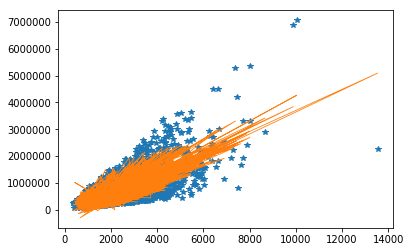

In [41]:
#plt.scatter(x_train['sqft_living'],y_train ,color = 'r')
plt.plot(x_train['sqft_living'],y_train ,'*',x_train['sqft_living'] ,model2.predict(x_train) ,'-', linewidth =.8)

In [42]:
#here max_penalty we got is taken to get back first l1_penalty value
model3 =Lasso(alpha=297.16)
model3.fit(x_train,y_train)
price_predicted = model3.predict(x_test)
RSS = ((price_predicted-y_test)**2).sum()
print (RSS)
print (model3.coef_)

386788462905435.6
[ 9.02651204e+03  5.01782356e+04  7.31363011e+02  5.89681397e-01
 -0.00000000e+00  6.06522280e+05  4.61141538e+04  3.33316772e+04
  1.00836318e+05 -1.10963200e+02 -1.31640826e+02 -2.51029401e+03
  3.82872950e+01 -6.04975194e+02  5.79731876e+05 -1.53734893e+05
  4.99618863e+01 -2.22139382e-01 -4.61658754e+04 -4.58167859e+02
 -3.63801550e+03  2.29006121e+03]


C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
